In [3]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import geopandas as gpd
A = gpd.read_file('data/Chicago/Boundaries - Community Areas (current).zip')

In [5]:
column_names = ['POP_DENS','VAC_HU','HH_SIZE']
model_name = 'cox_hawkes'
model = Point_Process_Model('data/Chicago/Crime_Incident_Reports/sr_2022_xyt.csv',
                            A,model=model_name,
                            #spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(1,10), alpha = dist.Beta(5,15), sigmax_2 = dist.HalfNormal(0.1),
                            w=dist.Normal(np.zeros(3),np.ones(3)/10)
                           )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:216: UserWarning: "w" prior is not being used. There is no such parameter in the model.
  warnings.warn(f'\"{par}\" prior is not being used. There is no such parameter in th

In [92]:
column_names = ['POP_DENS','VAC_HU','HH_SIZE']
model_name = 'cox_hawkes'
old_model = Point_Process_Model('data/Chicago/Crime_Incident_Reports/sr_2022_xyt.csv',
                            A,model=model_name,
                            #spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(1,5), alpha = dist.Beta(2,8), sigmax_2 = dist.HalfNormal(0.1)
                           )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:80: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [69]:
import dill
with open('output/Chicago_Shootings/cox_hawkes/output.pkl','rb') as f:
    ouput = dill.load(f)

In [70]:
old_model.mcmc_samples = ouput['samples']

In [17]:
model.mcmc_samples['a_0'].mean()

DeviceArray(1.127845, dtype=float32)

## SVI Results

100%|███████████████| 20000/20000 [07:46<00:00, 42.86it/s, init loss: -11133.9443, avg. loss [19001-20000]: -22648.0605]



SVI elapsed time: 481.2733316421509


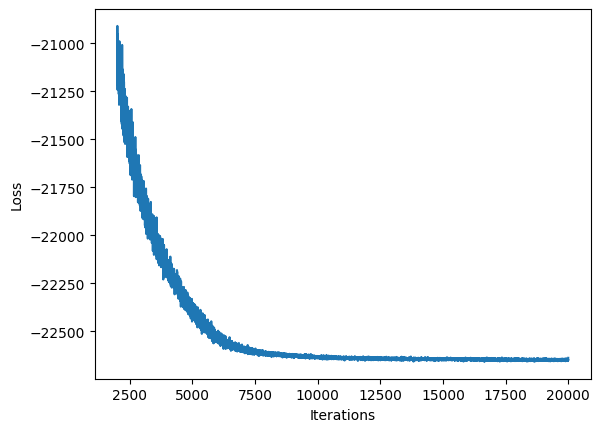

In [7]:
from numpyro.infer import init_to_median, init_to_value, init_to_uniform
model.run_svi(num_steps=20000,lr=0.002,resume=False)

(-22000.0, -20000.0)

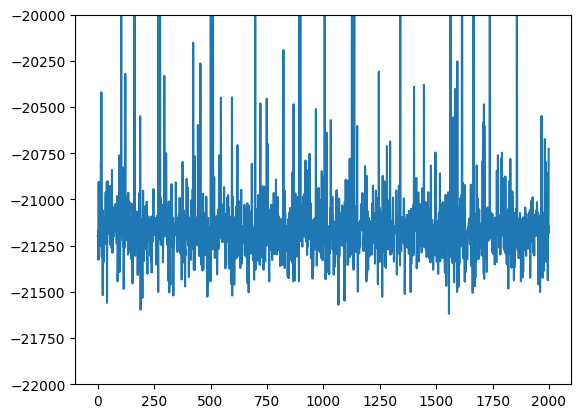

In [26]:
import matplotlib.pyplot as plt
plt.plot(model.svi_results.losses)
plt.ylim(-22000,-20000)

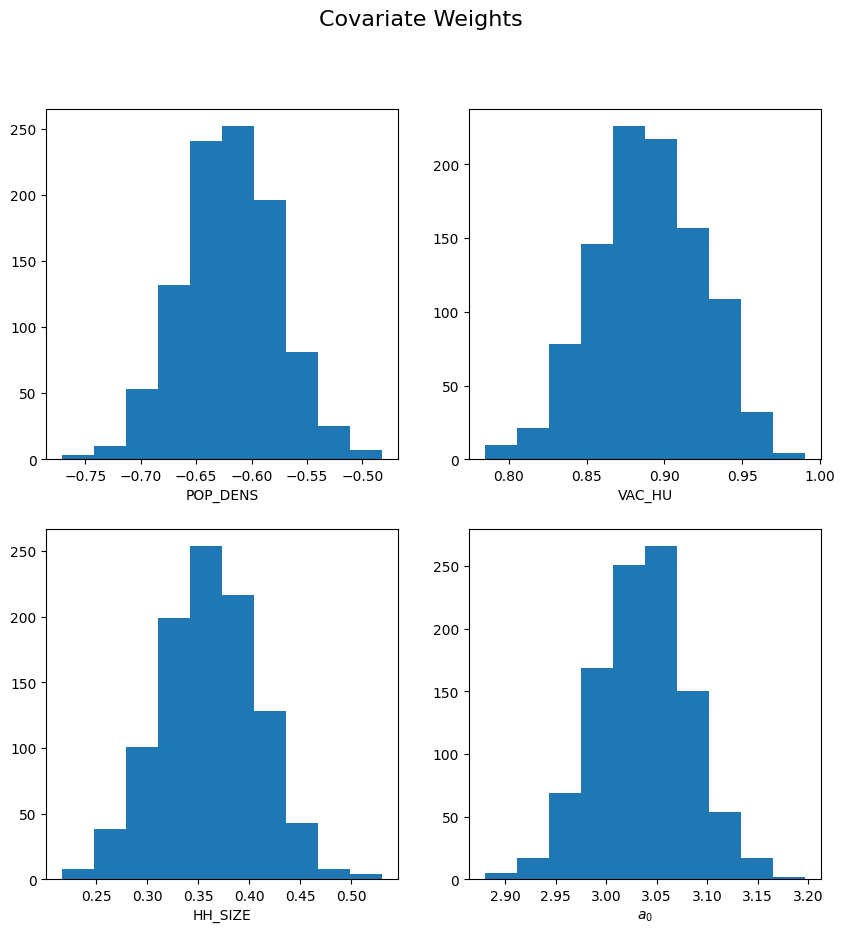

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,-0.619744,0.042607,-14.545459,0.000000e+00,-0.698848,-0.536971
VAC_HU,0.889598,0.034426,25.840708,0.000000e+00,0.823012,0.952136
HH_SIZE,0.361179,0.047378,7.623426,2.475797e-14,0.269176,0.452929
a_0,3.036171,0.045859,66.207146,0.000000e+00,2.944908,3.126458


In [8]:
model.cov_weight_post_summary()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:527: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


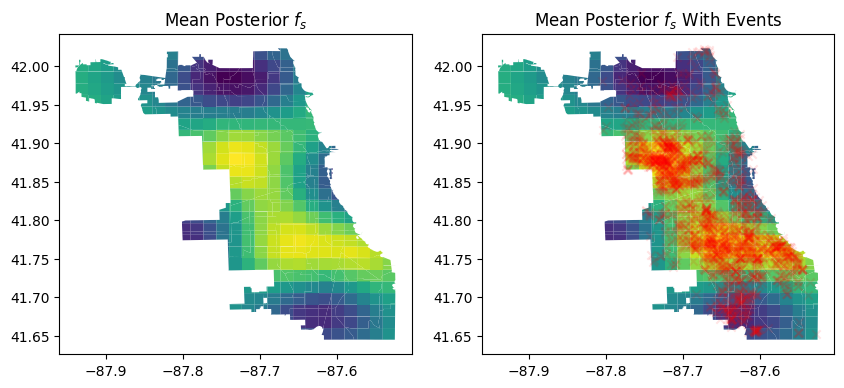

In [8]:
model.plot_spatial_background(include_cov=False)

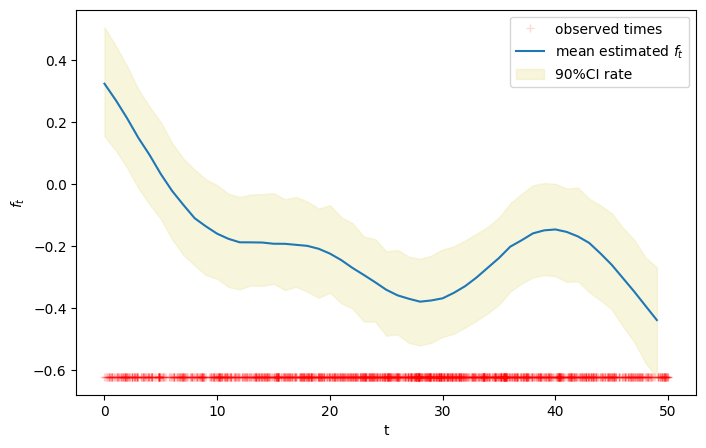

In [22]:
model.plot_temporal_background()

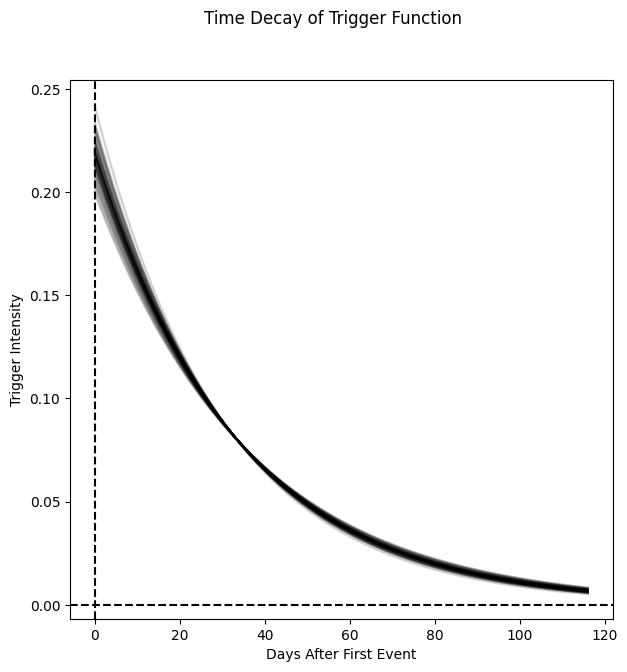

Mean trigger time: 33.29 days


In [15]:
model.plot_trigger_time_decay()

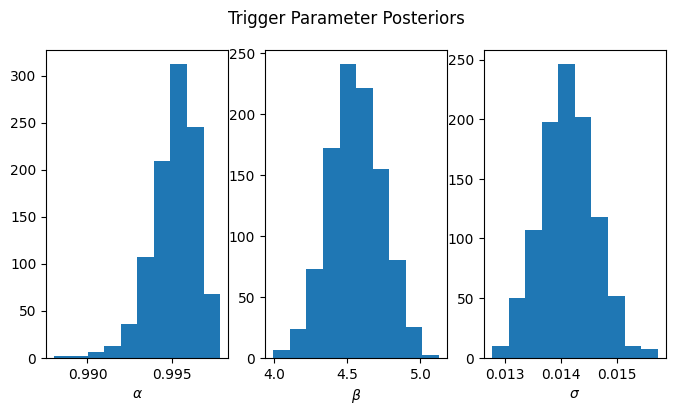

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.995135,0.001339,742.969238,0.0,0.992207,0.997245
beta,4.557435,0.179738,25.355959,0.0,4.208877,4.904003
sigma,0.014115,0.000478,29.515148,0.0,0.013169,0.015010


In [9]:
model.plot_trigger_posterior()

In [8]:
model.mcmc_samples['sigmax_2'].mean()**0.5*.6*110

DeviceArray(0.7651586, dtype=float32)

In [10]:
model.mcmc_samples['z_spatial'].mean(axis=0)

DeviceArray([ 0.61252683,  0.15039343, -0.03544884,  0.38549712,
             -1.4832615 ,  1.2499362 ,  3.0758078 ,  0.44048643,
             -0.1067792 , -0.38999072, -0.188749  ,  0.64770466,
              1.1004956 , -1.5884882 , -0.04313138, -3.1112473 ,
             -1.9329103 , -0.5442944 , -1.0000234 ,  0.43976024],            dtype=float32)

## MCMC Results

In [4]:
#import numpyro
#numpyro.set_host_device_count(3)
model.run_mcmc(num_warmup=1000,num_chains=1)

sample: 100%|█████████████████████████| 2000/2000 [5:41:38<00:00, 10.25s/it, 255 steps of size 1.06e-02. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0    -15.52      1.68    -15.47    -18.24    -12.86    413.35      1.00
         alpha      0.91      0.03      0.91      0.87      0.95   1273.11      1.00
          beta     15.87      1.10     15.80     14.08     17.61    839.07      1.00
      sigmax_2      0.00      0.00      0.00      0.00      0.00    580.19      1.00
  z_spatial[0]     -0.56      0.11     -0.56     -0.73     -0.39    453.82      1.00
  z_spatial[1]      0.53      0.14      0.53      0.28      0.75    431.25      1.00
  z_spatial[2]     -0.96      0.19     -0.97     -1.26     -0.64    445.81      1.00
  z_spatial[3]     -1.93      0.22     -1.93     -2.28     -1.57    389.80      1.00
  z_spatial[4]     -0.21      0.18     -0.21     -0.49      0.07    528.98      1.00
  z_spatial[5]      0.09      0.11      0.09     -0.09      0.26    515.48      1.00
  z_spatial[6]      0.31      0.20      0.31     -0.03      0.64

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:501: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


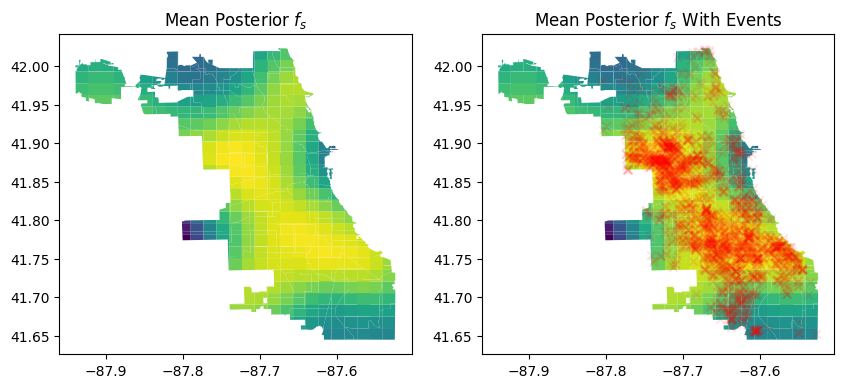

In [9]:
model.plot_spatial_background(include_cov=False)

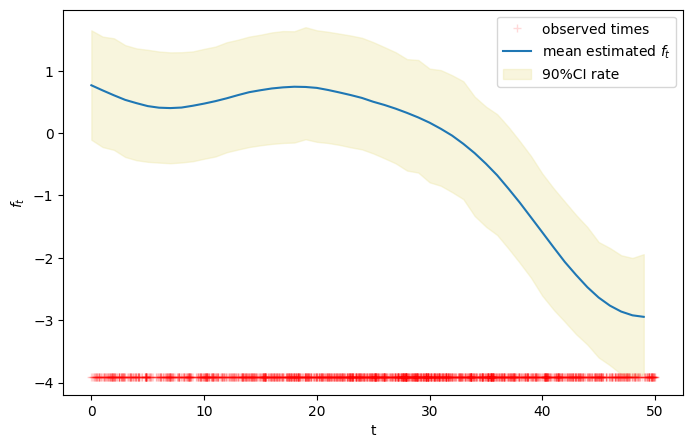

In [17]:
model.plot_temporal_background()

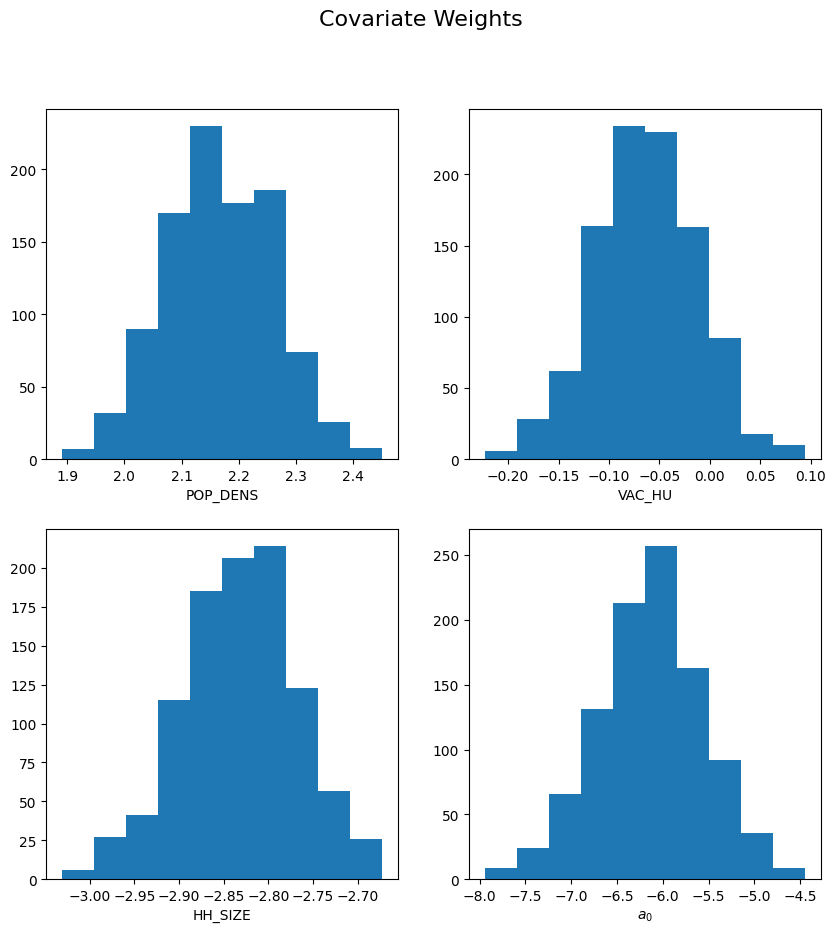

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,2.167948,0.094825,22.862608,0.000000,1.989814,2.350165
VAC_HU,-0.062866,0.051447,-1.221938,0.221731,-0.163786,0.033729
HH_SIZE,-2.831886,0.063915,-44.307373,0.000000,-2.964856,-2.707921
a_0,-6.130668,0.578547,-10.596660,0.000000,-7.325783,-4.950991


In [67]:
model.cov_weight_post_summary()

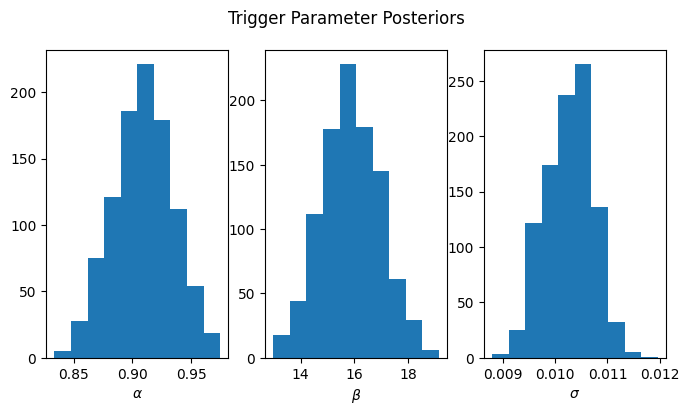

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.909119,0.025481,35.678703,0.0,0.858621,0.959603
beta,15.868416,1.095039,14.491181,0.0,13.724214,18.159210
sigma,0.010264,0.000455,22.570568,0.0,0.009374,0.011074


In [11]:
model.plot_trigger_posterior()

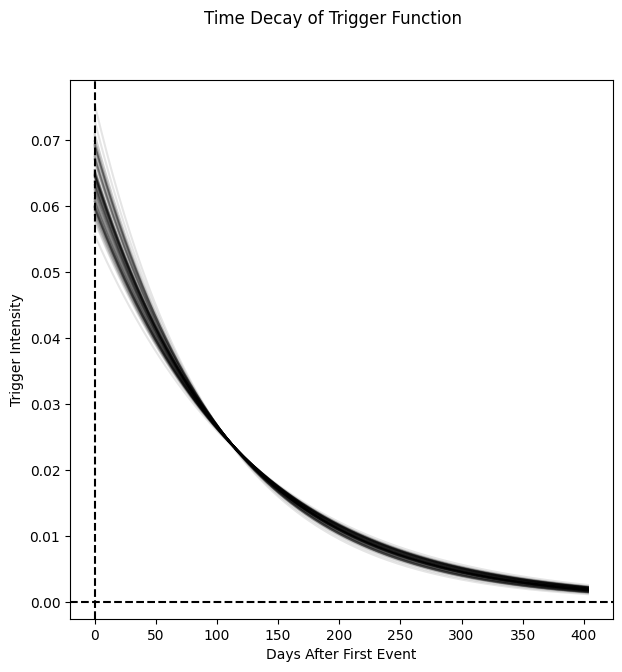

Mean trigger time: 115.7 days


In [12]:
model.plot_trigger_time_decay()

In [14]:
model.mcmc_samples['sigmax_2'].mean()**0.5*.6*110

DeviceArray(0.6780996, dtype=float32)

In [52]:
old_model.mcmc_samples['beta'] = 1/old_model.mcmc_samples['beta']

## ShotSpotter Results

In [27]:
column_names = ['POP_DENS','VAC_HU','HH_SIZE']
model_name = 'lgcp'
ss_mod = Point_Process_Model('data/Chicago/ShotSpotter/ss_2022_xyt.csv',
                            A,model=model_name,
                            spatial_cov='data/Chicago/spat_cov.shp',cov_names = column_names,
                            a_0=dist.Normal(1,5), alpha = dist.Beta(1,1)
                           )

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:78: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  args['A_area'] = A.area.sum()/((A_[0,1]-A_[0,0])*(A_[1,1]-A_[1,0]))
/home/imanring/PointProcess/Cox_Hawkes/cox_hawkes/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026
/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

### SVI Results

100%|█████████████| 50000/50000 [01:01<00:00, 810.85it/s, init loss: -22057.4258, avg. loss [47501-50000]: -518729.7188]



SVI elapsed time: 73.24894642829895


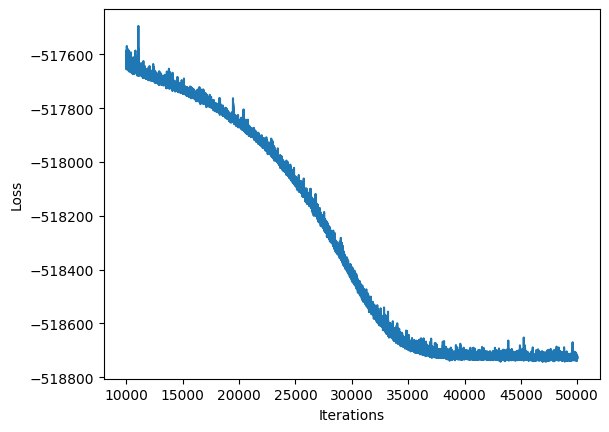

In [39]:
from numpyro.infer import init_to_median, init_to_value, init_to_uniform
ss_mod.run_svi(num_steps=50000,lr=0.005,init_strategy=init_to_uniform)

In [40]:
(np.exp(ss_mod.mcmc_samples['scale'])).mean()

25.529844

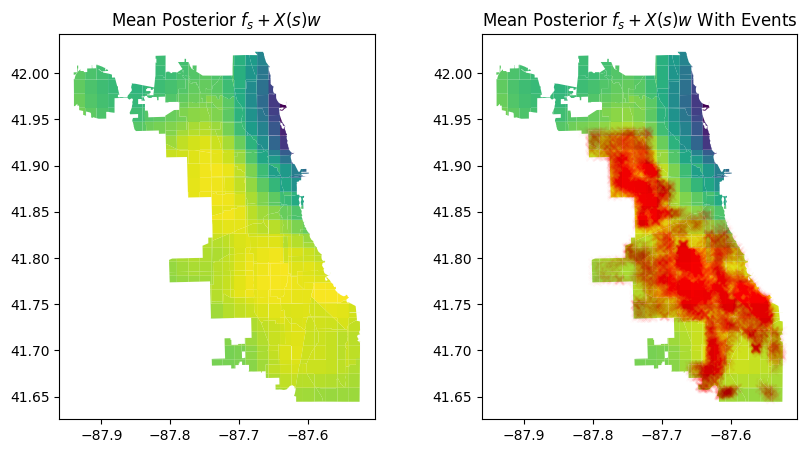

In [41]:
ss_mod.plot_spatial_background(alpha=0.01,include_cov=True)

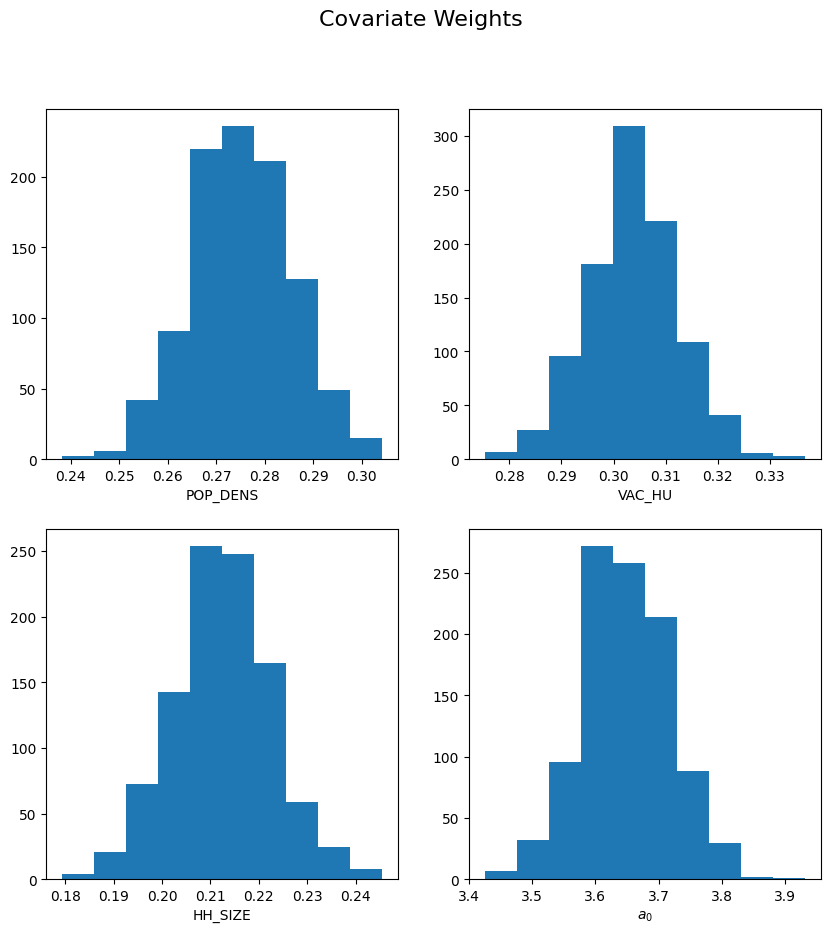

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,0.275364,0.010349,26.609087,0.0,0.255803,0.295338
VAC_HU,0.303745,0.008765,34.654545,0.0,0.286399,0.320949
HH_SIZE,0.212642,0.010202,20.842579,0.0,0.192596,0.233636
a_0,3.648959,0.070026,52.108517,0.0,3.511572,3.790881


In [42]:
ss_mod.cov_weight_post_summary()

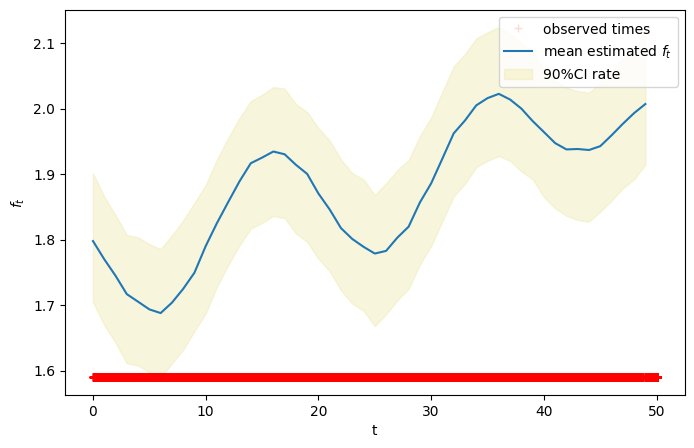

In [43]:
ss_mod.plot_temporal_background()

### MCMC Results

In [10]:
ss_mod.run_mcmc()

sample: 100%|██████████████████████████| 1500/1500 [05:22<00:00,  4.65it/s, 1023 steps of size 3.11e-03. acc. prob=0.92]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0      7.68      0.43      7.70      7.03      8.44    114.90      1.03
         scale      6.46      0.03      6.46      6.40      6.51    433.99      1.00
          w[0]      0.27      0.01      0.27      0.25      0.29    775.46      1.00
          w[1]      0.31      0.01      0.31      0.29      0.32    991.11      1.00
          w[2]      0.23      0.01      0.23      0.21      0.24    664.83      1.00
  z_spatial[0]      0.12      0.04      0.12      0.06      0.18     66.43      1.00
  z_spatial[1]      2.08      0.17      2.08      1.82      2.37     65.08      1.00
  z_spatial[2]     -0.13      0.02     -0.13     -0.17     -0.10     65.70      1.00
  z_spatial[3]      0.14      0.02      0.14      0.12      0.17    307.26      1.00
  z_spatial[4]      1.48      0.08      1.48      1.36      1.63     67.86      1.00
  z_spatial[5]     -0.51      0.04     -0.51     -0.59     -0.45

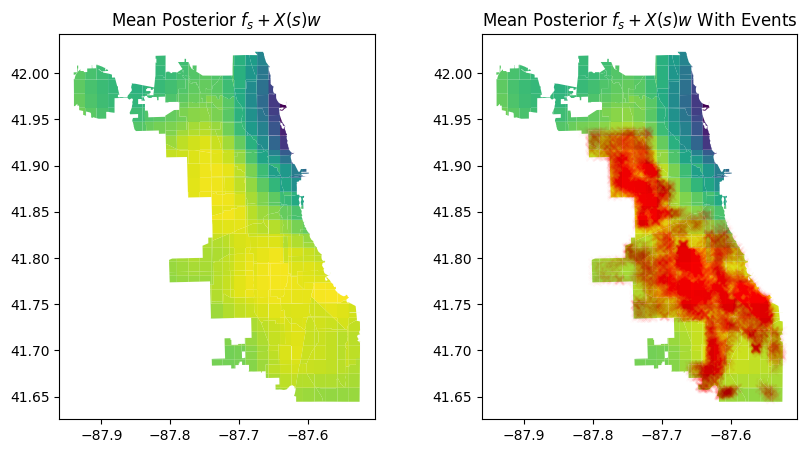

In [13]:
ss_mod.plot_spatial_background(alpha=0.01,include_cov=True)

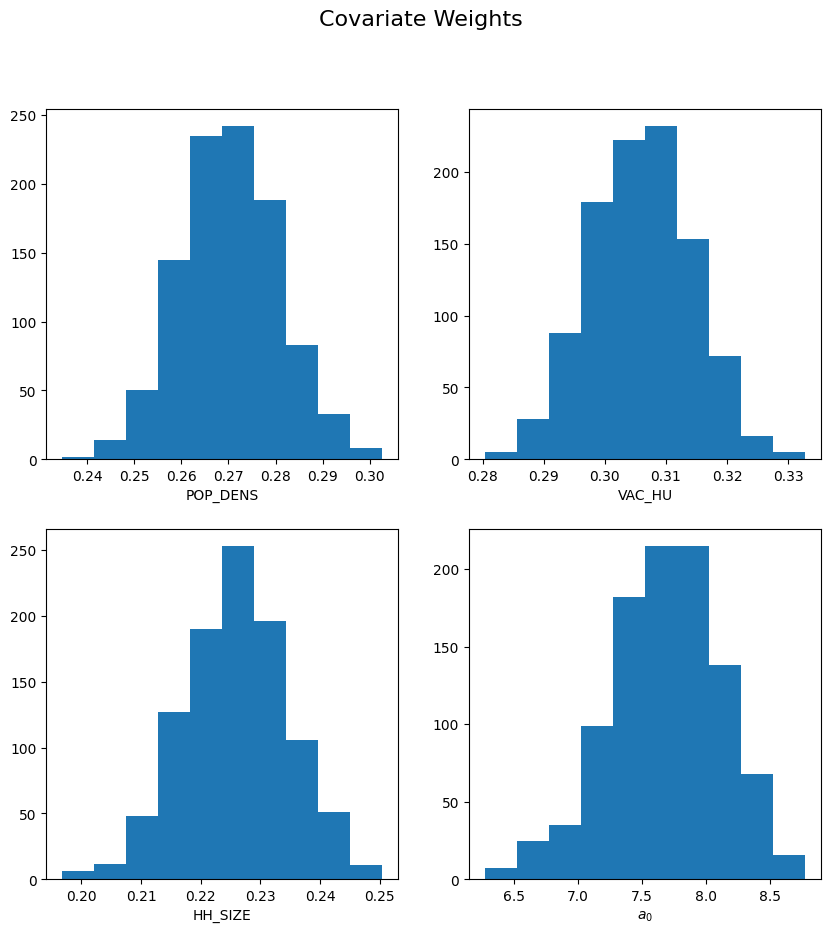

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
POP_DENS,0.270330,0.010486,25.779121,0.0,0.251202,0.292155
VAC_HU,0.306021,0.008370,36.561749,0.0,0.289961,0.321770
HH_SIZE,0.225911,0.008793,25.690805,0.0,0.208978,0.242395
a_0,7.683185,0.434649,17.676737,0.0,6.718726,8.478019


In [14]:
ss_mod.cov_weight_post_summary()

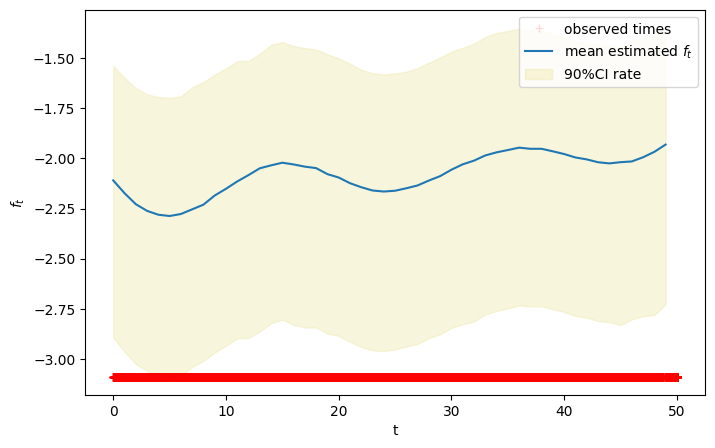

In [15]:
ss_mod.plot_temporal_background()

In [16]:
ss_mod.mcmc_samples['a_0'].mean()

DeviceArray(7.683186, dtype=float32)

## Boko Haram

In [16]:
A = np.array([[3,15.5],[4,16.5]])
column_names = ['droughtstart_speibase', 'urban_ih_log', 'droughtyr_speigdm',
       'herb_gc', 'capdist', 'grass_ih_log', 'nlights_sd_log', 'water_gc_log',
       'pop_gpw_sd_log', 'pasture_ih']
model_name = 'cox_hawkes'
model = Point_Process_Model('data/spt_data.csv',A,model=model_name,
                            #spatial_cov='data/inc_spatial_cov.csv',cov_grid_size=(0.5,0.5),
                            #cov_names = column_names,
                            a_0=dist.Normal(0,5)
                           )

100%|████████████████| 10000/10000 [00:12<00:00, 785.15it/s, init loss: -3819.0354, avg. loss [9501-10000]: -29366.7871]



SVI elapsed time: 16.06929326057434


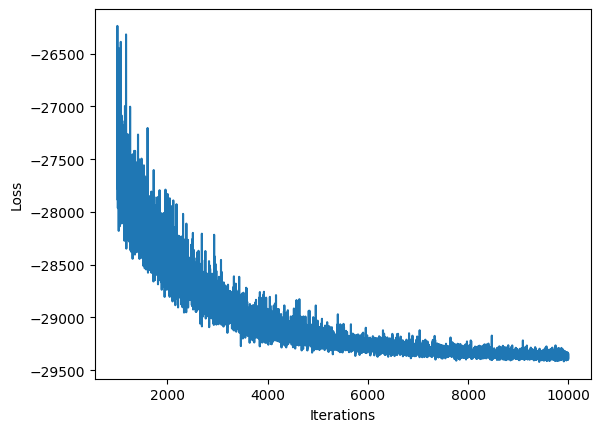

In [28]:
model.run_svi(num_steps=10000,resume=False)

In [ ]:
model.run_mcmc()

warmup:   4%|█                         | 58/1500 [09:11<10:07:42, 25.29s/it, 511 steps of size 1.52e-03. acc. prob=0.73]

In [ ]:
model.plot_spatial_background(include_cov=True)

In [ ]:
model.plot_temporal_background()

In [ ]:
model.plot_trigger_posterior()

In [ ]:
model.cov_weight_post_summary()

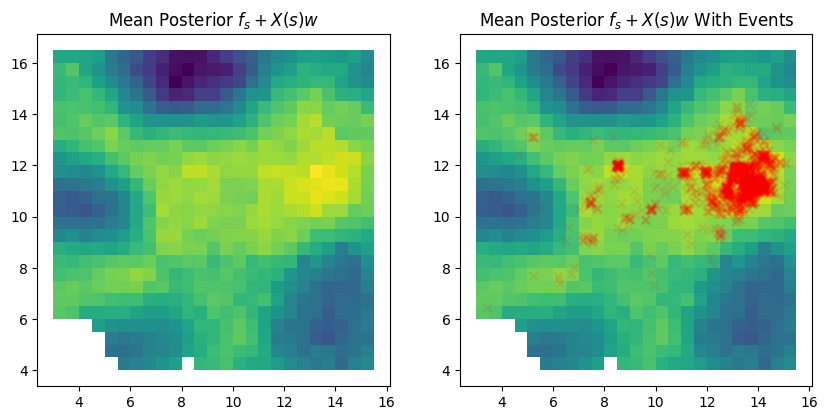

In [5]:
model.plot_spatial_background(include_cov=True)

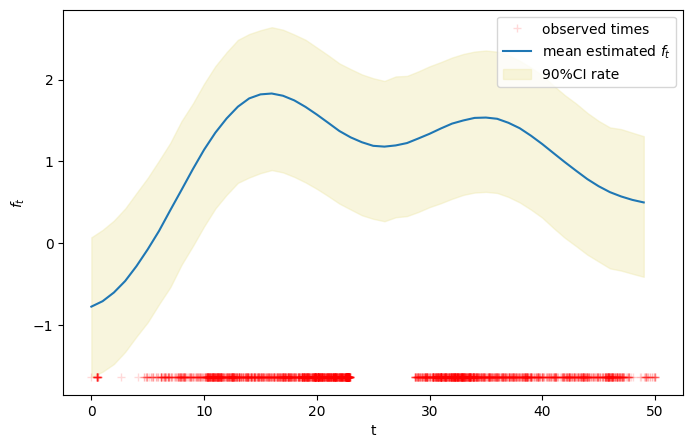

In [6]:
model.plot_temporal_background()

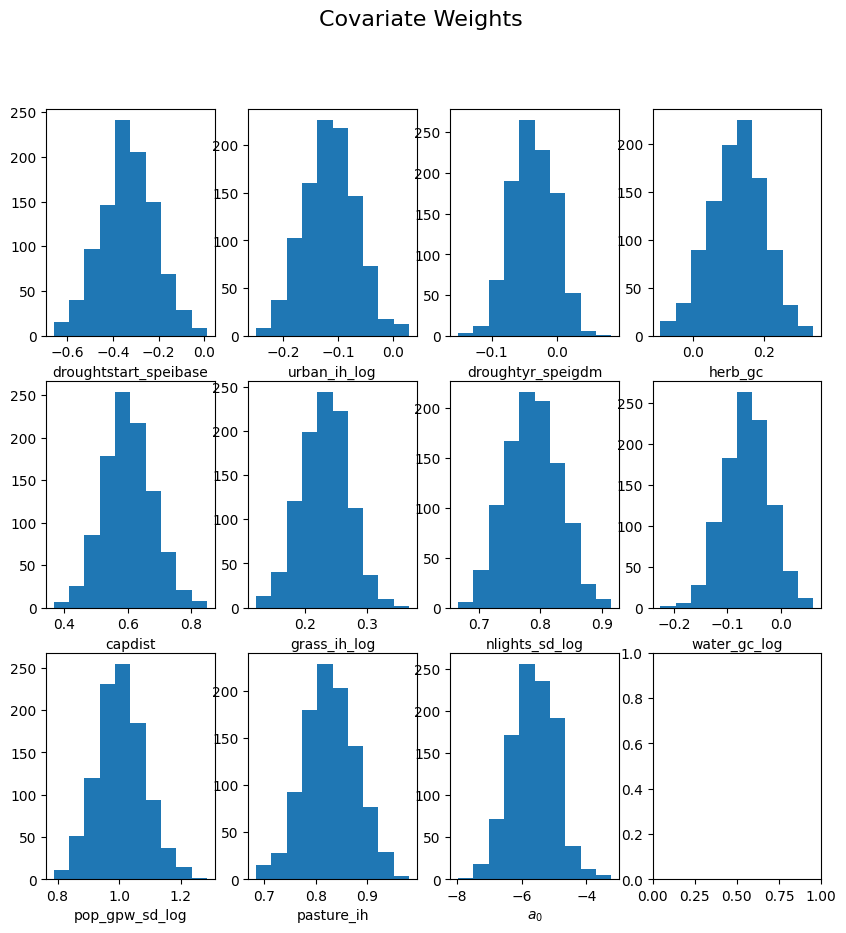

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
droughtstart_speibase,-0.333920,0.118171,-2.825723,4.717402e-03,-0.574770,-0.101631
urban_ih_log,-0.113845,0.047393,-2.402149,1.629908e-02,-0.202341,-0.021521
droughtyr_speigdm,-0.037254,0.031896,-1.167961,2.428227e-01,-0.097778,0.023123
herb_gc,0.124772,0.076057,1.640509,1.008994e-01,-0.021036,0.266220
capdist,0.600671,0.076932,7.807808,5.773160e-15,0.456084,0.758126
grass_ih_log,0.231869,0.038233,6.064639,1.322505e-09,0.155187,0.306656
nlights_sd_log,0.787875,0.042888,18.370705,0.000000e+00,0.705801,0.871064
water_gc_log,-0.062565,0.042735,-1.464036,1.431842e-01,-0.143146,0.021565
pop_gpw_sd_log,1.005470,0.077319,13.004135,0.000000e+00,0.864093,1.164991
pasture_ih,0.827885,0.050629,16.352047,0.000000e+00,0.728378,0.928618


In [9]:
model.cov_weight_post_summary()

# Test on Simulation

In [2]:
from bstpp.main import Point_Process_Model
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_bg(T):
    centers = np.random.normal(size=10).reshape(5,2)
    n = np.random.poisson(np.random.gamma(150,1,size=5),size=5)
    bg = list()
    for i in range(5):
        bg.append(np.stack((np.random.normal(loc=centers[i,0],size=n[i]),
                                   np.random.normal(loc=centers[i,1],size=n[i]),
                                   np.random.uniform(size=n[i])*T)).T)
    return np.concatenate(bg)

def gen_bg(T):
    n = np.random.poisson(750,size=1)
    return np.stack((np.random.uniform(-5,5,size=n),np.random.uniform(-5,5,size=n),
                     np.random.uniform(0,T,size=n))).T

def gen_dat(par,T):
    r_0, b, sigma_1, sigma_2 = par
    #bg = gen_bg(T)
    n_bg = np.random.poisson(750,size=1)
    bg = np.stack((np.random.normal(size=n_bg),np.random.normal(size=n_bg),np.random.uniform(size=n_bg)*T)).T
    i = 0
    while i < len(bg):
        for j in range(np.random.poisson(lam=r_0)):
            bg = np.concatenate((bg,[bg[i]+[np.random.normal(scale=sigma_1), 
                                           np.random.normal(scale=sigma_2), 
                                           np.random.exponential(b)]]))
        i += 1
    return bg
par = np.array([.25,1,.1,.1])
events = gen_dat(par,365)
events = events[np.logical_and(abs(events.T[0])<5,abs(events.T[1])<5,events.T[2]<365)]
events = events[events[:, 2].argsort()]
len(events)

1044

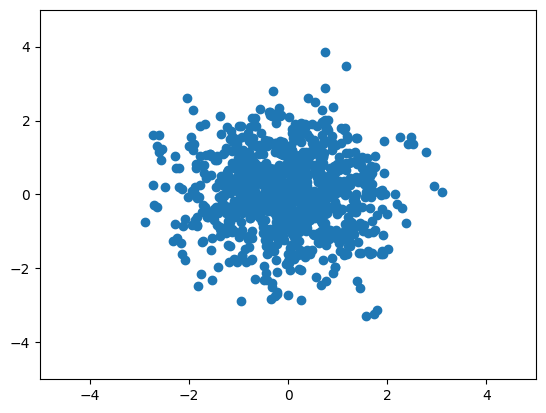

In [3]:
plt.scatter(events.T[0],events.T[1])
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.show()

In [4]:
import pandas as pd
xyt = pd.DataFrame(events,columns=['X','Y','T'])
A = np.array([[-5,5],[-5,5]])

In [5]:
model = Point_Process_Model(xyt,A,'cox_hawkes',
                            alpha=dist.Beta(5,15),beta=dist.HalfNormal(.2),sigmax_2=dist.HalfNormal(.01)
                           )

In [ ]:
model.run_mcmc()

warmup:  16%|███▉                     | 236/1500 [10:48<1:17:56,  3.70s/it, 1023 steps of size 6.84e-03. acc. prob=0.77]

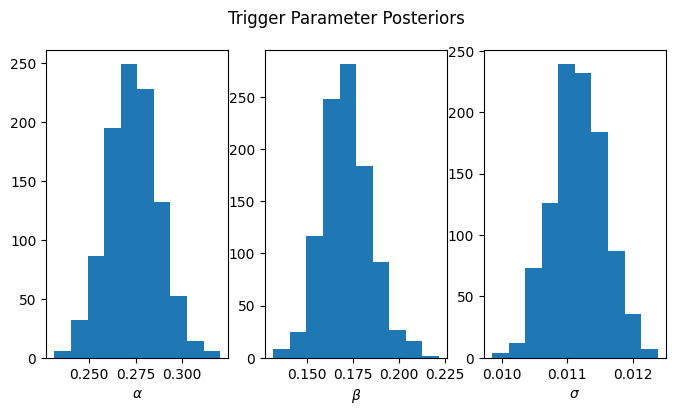

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.273662,0.013811,19.814476,0.0,0.246818,0.300657
beta,0.171597,0.013052,13.147371,0.0,0.148661,0.199526
sigma,0.011174,0.000400,27.916367,0.0,0.010407,0.011971


In [7]:
model.plot_trigger_posterior()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:530: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


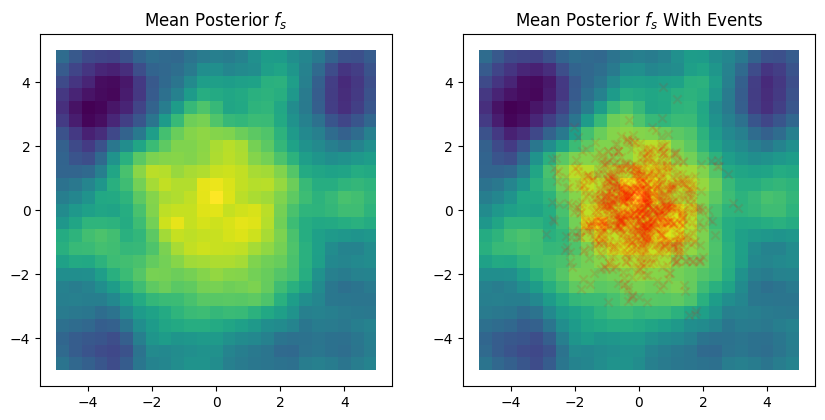

In [8]:
model.plot_spatial_background()

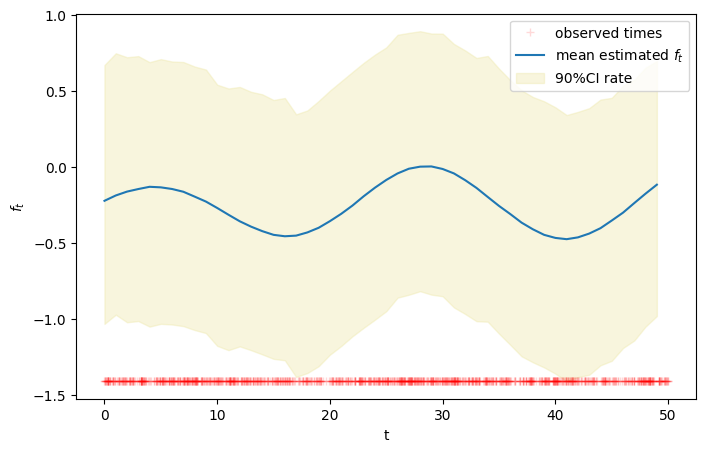

In [9]:
model.plot_temporal_background()

(array([  7.,  28.,  78., 178., 246., 235., 149.,  58.,  20.,   1.]),
 array([694.2012 , 707.9493 , 721.6973 , 735.44543, 749.19354, 762.94165,
        776.6897 , 790.4378 , 804.1859 , 817.93396, 831.68207],
       dtype=float32),
 <BarContainer object of 10 artists>)

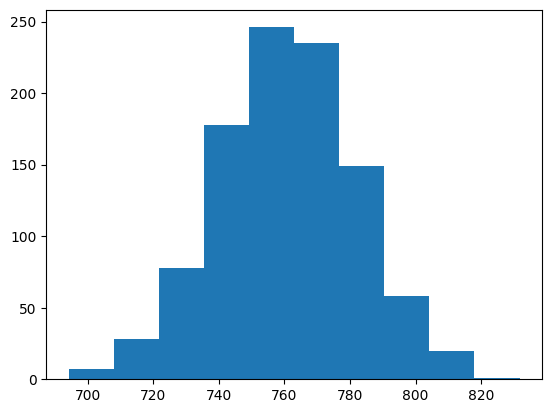

In [42]:
plt.hist(model.mcmc_samples['Itot_txy_back'])

In [15]:
model = Point_Process_Model(xyt,A,'cox_hawkes',
                            alpha=dist.Beta(5,15),beta=dist.HalfNormal(.2),sigmax_2=dist.HalfNormal(.01)
                           )

100%|███████████████████████| 100000/100000 [11:18<00:00, 147.42it/s, init loss: 25664.0723, avg. loss [95001-100000]: -8034.0063]



SVI elapsed time: 699.5545551776886


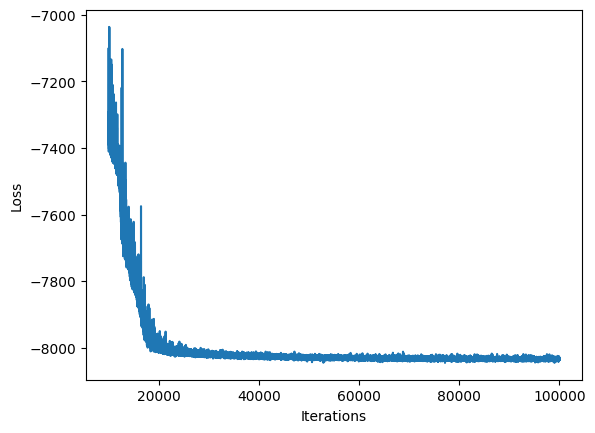

In [16]:
model.run_svi(num_steps=100000,lr=.001,resume=False)

In [12]:
model.run_mcmc()

warmup:   3%|▉                                      | 38/1500 [00:11<07:05,  3.44it/s, 255 steps of size 1.69e-03. acc. prob=0.71]


KeyboardInterrupt: 

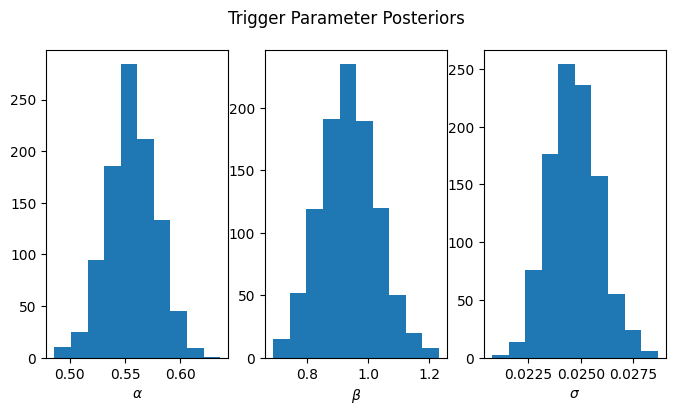

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.556086,0.022160,25.093712,0.0,0.513620,0.599585
beta,0.935652,0.093101,10.049908,0.0,0.757787,1.126753
sigma,0.024699,0.001198,20.616205,0.0,0.022526,0.027179


In [17]:
model.plot_trigger_posterior()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:528: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


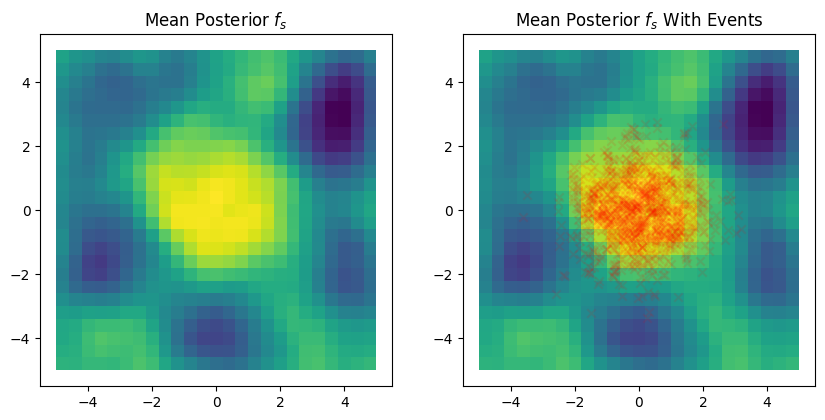

In [18]:
model.plot_spatial_background(include_cov=False)

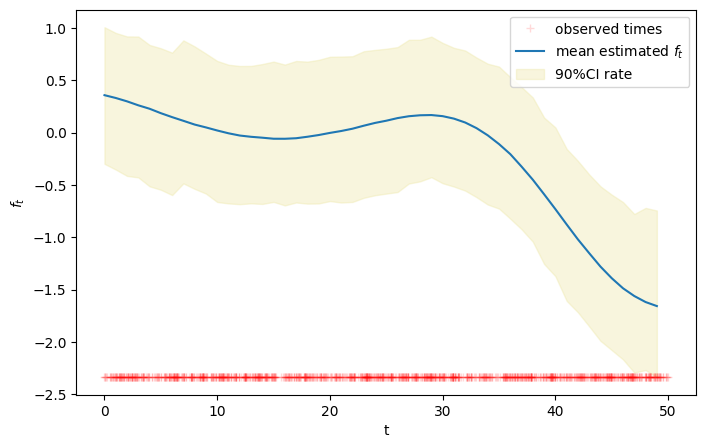

In [19]:
model.plot_temporal_background()

In [56]:
model2 = Point_Process_Model(xyt,A,'lgcp')

In [57]:
model2.run_mcmc()

sample: 100%|█████████████████████████████████████| 1500/1500 [00:15<00:00, 94.78it/s, 255 steps of size 2.02e-02. acc. prob=0.93]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -1.70      0.84     -1.69     -3.15     -0.43    450.18      1.00
  z_spatial[0]      0.58      0.08      0.58      0.45      0.71    743.20      1.00
  z_spatial[1]     -0.45      0.13     -0.44     -0.63     -0.23    535.38      1.00
  z_spatial[2]      0.30      0.07      0.30      0.20      0.42    606.76      1.00
  z_spatial[3]      0.42      0.06      0.42      0.33      0.52    408.64      1.00
  z_spatial[4]     -0.17      0.06     -0.17     -0.27     -0.07    803.80      1.00
  z_spatial[5]      0.27      0.08      0.27      0.14      0.40    476.49      1.00
  z_spatial[6]      0.73      0.07      0.73      0.61      0.85    758.40      1.00
  z_spatial[7]      0.48      0.10      0.47      0.32      0.65    521.24      1.00
  z_spatial[8]     -1.08      0.09     -1.08     -1.23     -0.94    575.46      1.00
  z_spatial[9]      0.24      0.06      0.24      0.14      0.33

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:528: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


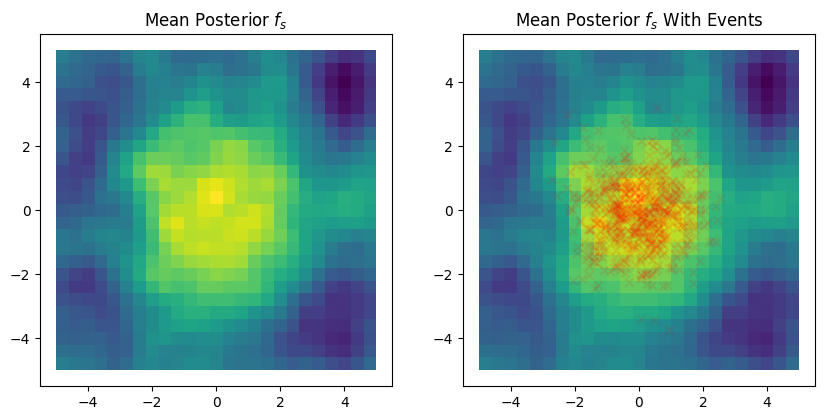

In [58]:
model2.plot_spatial_background(include_cov=False)

In [59]:
model2.mcmc_samples['f_xy'][0].min(),model2.mcmc_samples['f_xy'][0].max()

(DeviceArray(-7.040725, dtype=float32), DeviceArray(8.512199, dtype=float32))

In [60]:
model2.mcmc_samples['a_0'].mean()

DeviceArray(-1.6960607, dtype=float32)

In [61]:
model2.mcmc_samples['f_xy'][0].max()-model2.mcmc_samples['a_0'][0]

DeviceArray(11.192968, dtype=float32)

In [62]:
np.exp(model2.mcmc_samples['f_xy'][0].max()+model2.mcmc_samples['a_0'][0]+
       model2.mcmc_samples['f_t'][0].mean())

487.73495

In [63]:
def dnorm(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
intensity = lambda x,y: dnorm(x)*dnorm(y)*750*100/365*50

In [65]:
intensity(-5,-5),model2.mcmc_samples['f_xy'][0,0]+model2.mcmc_samples['a_0'][0]

(2.2708920364641638e-08, DeviceArray(-2.8980148, dtype=float32))

In [43]:
i,c = np.unique(model2.args['indices_xy'],return_counts=True)
i[np.argmax(c)]

287

In [46]:
np.argmax(model2.mcmc_samples['f_xy'][0]),model2.mcmc_samples['f_xy'][0,337],model2.mcmc_samples['f_xy'][0,287]

(DeviceArray(337, dtype=int32),
 DeviceArray(10.922717, dtype=float32),
 DeviceArray(9.782042, dtype=float32))

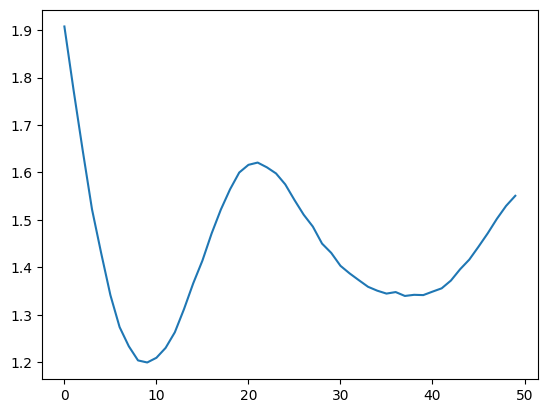

In [67]:
plt.plot(np.exp(model2.mcmc_samples['f_t'][0]))

In [32]:
model2.mcmc_samples['f_t'][0].mean()

DeviceArray(-0.9036978, dtype=float32)

In [ ]:
1.33333*